In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import *
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
import matplotlib.pyplot as plt
import itertools

In [2]:
D = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
L = 'quality'
C = 'color'
DLC = D + [L] + [C]

wine_r = pd.read_csv("winequality-red.csv", sep=';')
wine_w = pd.read_csv("winequality-white.csv", sep=';')
wine_w[C]= np.zeros(wine_w.shape[0])
wine_r[C]= np.ones(wine_r.shape[0])
wine = pd.concat([wine_w,wine_r])

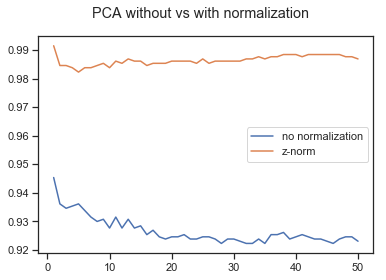

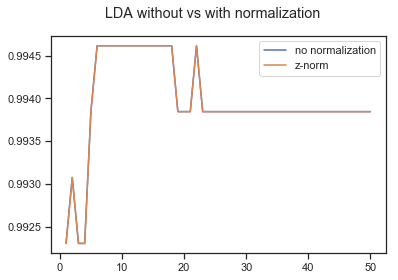

In [3]:
def compare(d, legend, name):
    X_train, X_test, y_train, y_test = train_test_split(d, np.ravel(wine[[C]]), test_size=0.2, random_state = 42)
    model = PCA(n_components=5).fit(X_train) if name == 'PCA' else LinearDiscriminantAnalysis().fit(X_train, y_train)
    plt.plot(range(1,51), [accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k).fit(model.transform(X_train), y_train).predict(model.transform(X_test))) for k in range(1,51)], label=legend)
    
for name in ['PCA', 'LDA']:
    fig = plt.figure()
    compare(wine[D].values, 'no normalization', name)
    compare(StandardScaler().fit_transform(wine[D]), 'z-norm', name)
    fig.suptitle(name + ' without vs with normalization')
    plt.legend()
    plt.show()

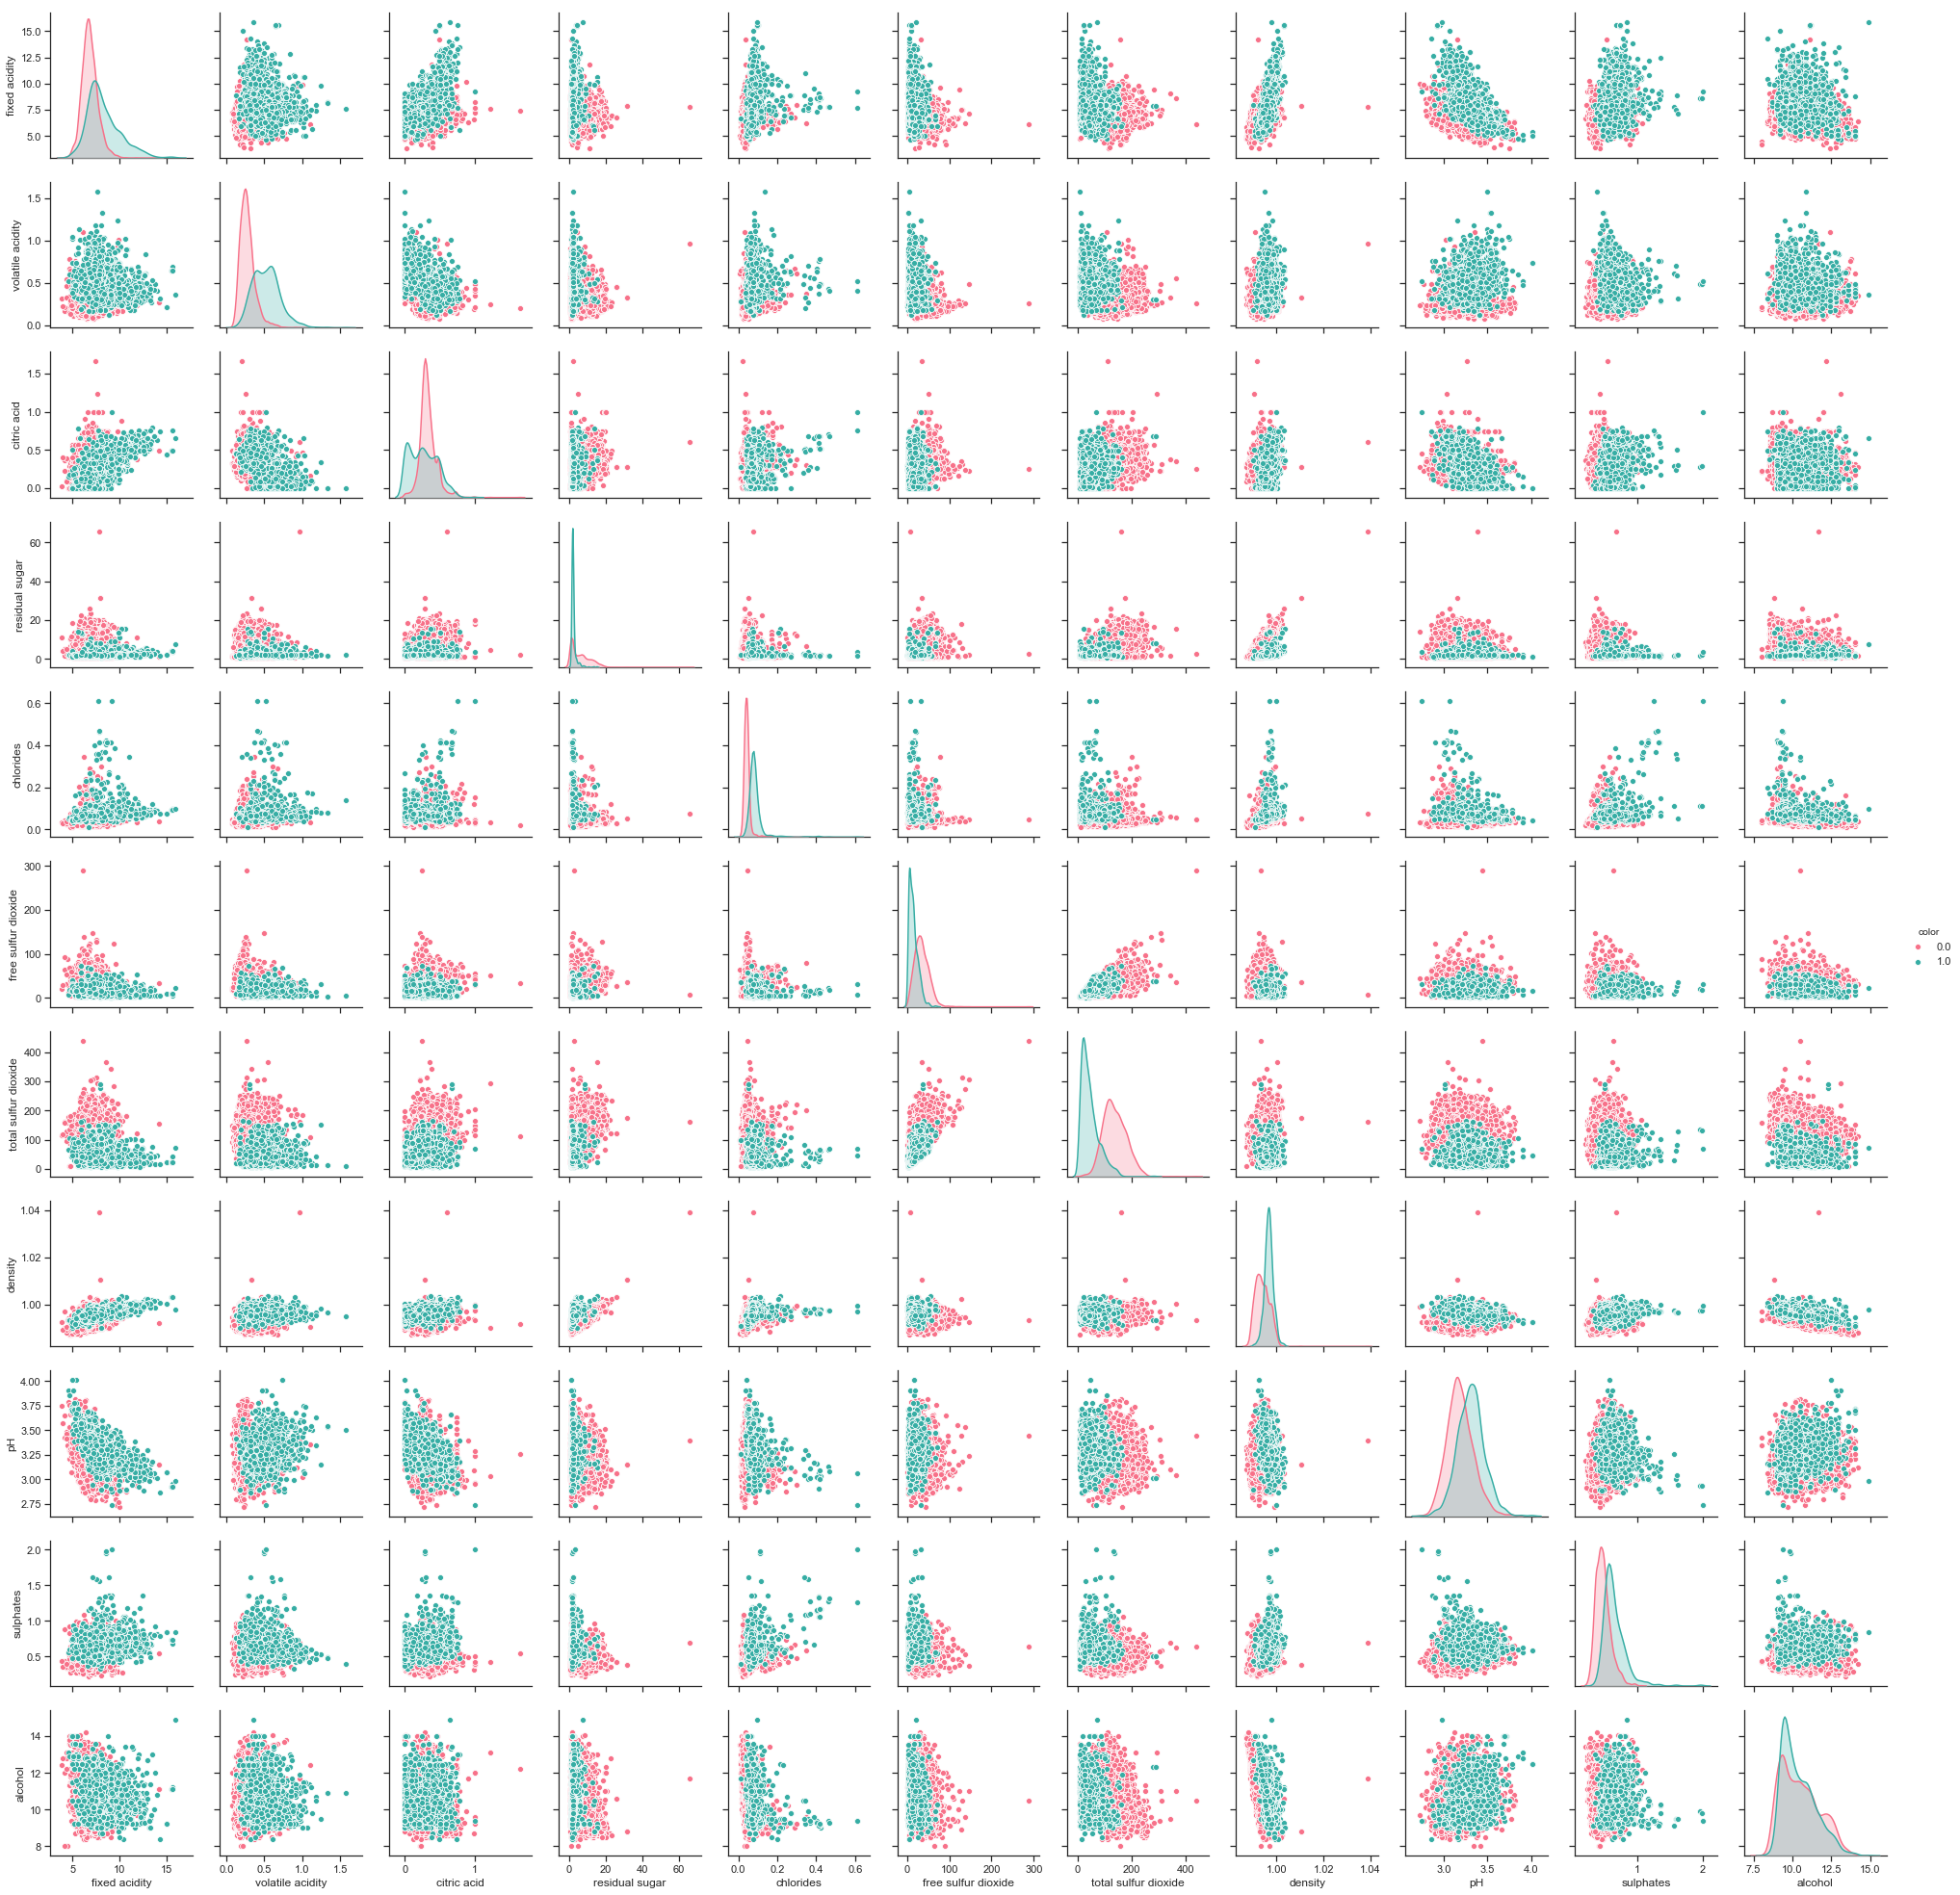

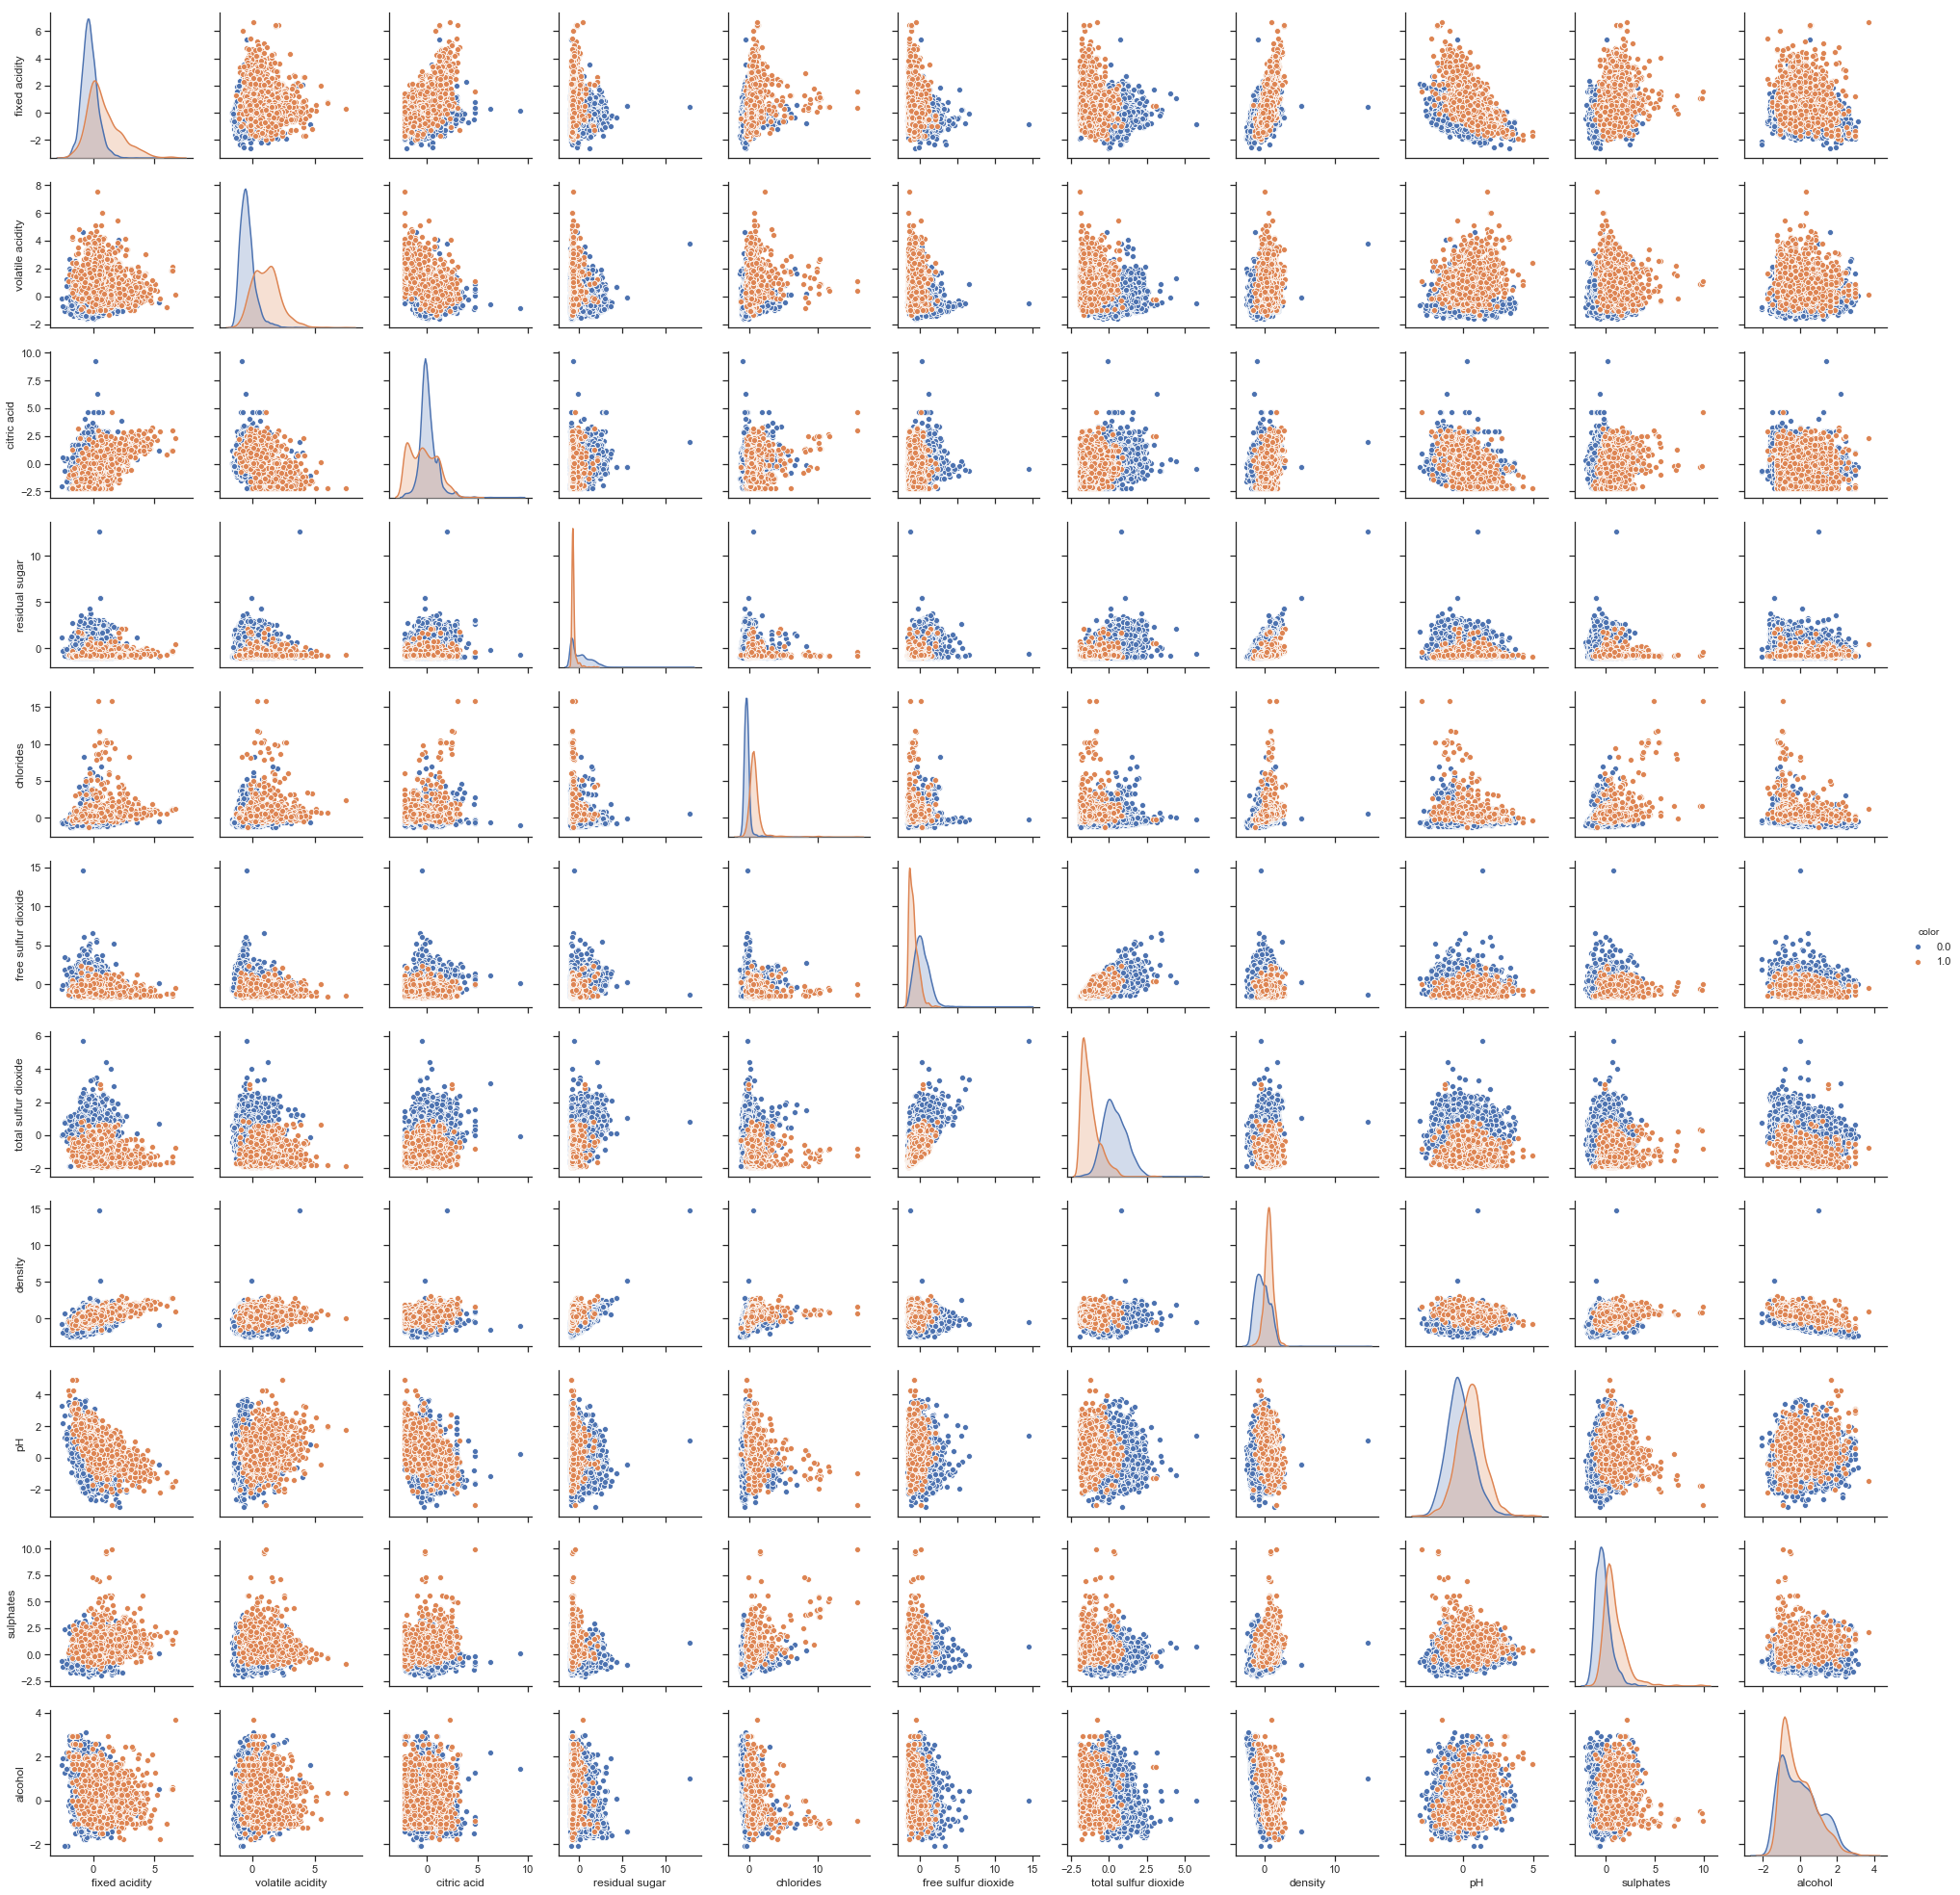

In [4]:
f = sns.pairplot(wine[DLC], vars = D, hue="color", palette="husl")
plt.show()
wine[D] = StandardScaler().fit_transform(wine[D])
f = sns.pairplot(wine[DLC], vars = D, hue="color")
plt.show()

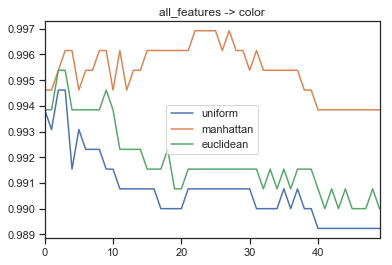

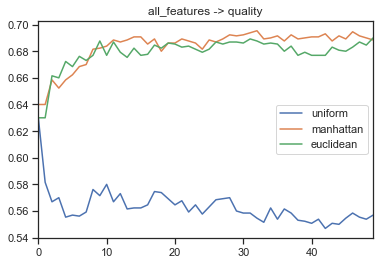

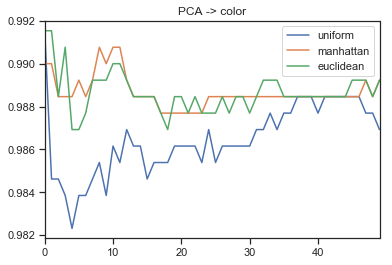

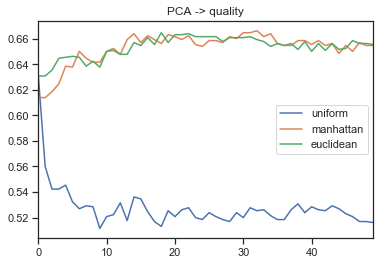

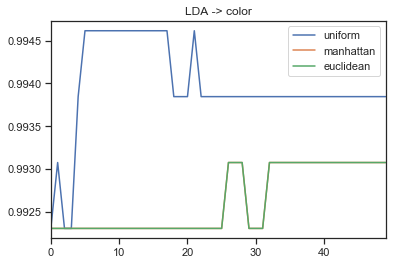

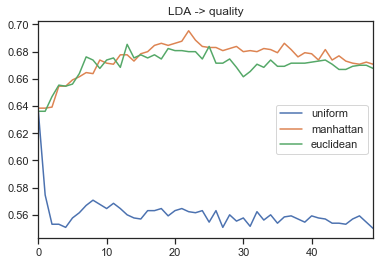

In [5]:
params = {
    'uniform': {},
    'manhattan': {'weights':"distance", 'p':1},
    'euclidean': {'weights':"distance", 'p':2}
}
for name in ['all_features', 'PCA', 'LDA']:
    for j in [C, L]:
        acc = pd.DataFrame(np.zeros((50,len(params))), columns=params.keys())
        X_train, X_test, y_train, y_test = train_test_split(wine[D].values, np.ravel(wine[[j]]), test_size=0.2, random_state = 42)
        if name != 'all_features':
            model = PCA(n_components=5).fit(X_train) if name == 'PCA' else LinearDiscriminantAnalysis().fit(X_train, y_train)
        for key, v in params.items():
            dataX = (X_train, X_test) if name == 'all_features' else (model.transform(X_train), model.transform(X_test))
            acc[key] = pd.Series([accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k, **params[key]).fit(dataX[0], y_train).predict(dataX[1])) for k in range(1,51)])
        f = acc.plot(kind = 'line', title = name + ' -> ' + j).get_figure()
        plt.show()

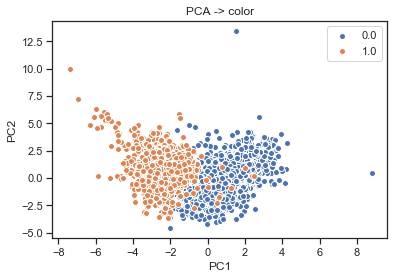

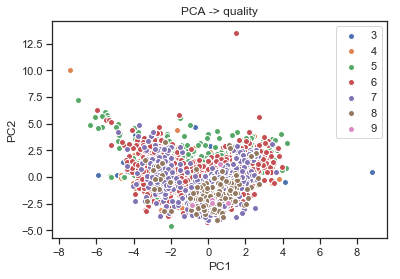

In [6]:
for j, k in zip([C, L], [[0.0, 1.0], sorted(np.unique(wine[[L]]))]):
    pcaDf = pd.DataFrame(data = PCA(n_components=2).fit_transform(wine[D].values), columns = ['PC1', 'PC2'])
    pcaDf.insert(2, j, wine[[j]].values, True)
    fig, ax = plt.subplots()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA -> ' + j)
    [ax.scatter(pcaDf.loc[pcaDf[j] == i, 'PC1'], pcaDf.loc[pcaDf[j] == i, 'PC2'], edgecolors='w') for i in k] 
    ax.legend(k)
    plt.show()

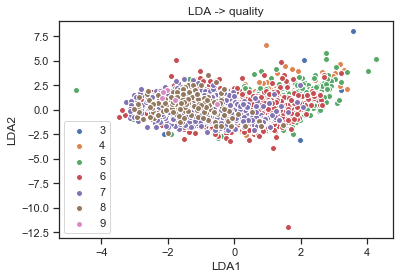

In [7]:
ldaDf = pd.DataFrame(data = LinearDiscriminantAnalysis(n_components=2).fit_transform(wine[D].values, np.ravel(wine[[L]])), columns = ['LDA1', 'LDA2'])
ldaDf.insert(2, L, wine[[L]].values, True)
fig, ax = plt.subplots()
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_title('LDA -> ' + L)
[ax.scatter(ldaDf.loc[ldaDf[L] == i, 'LDA1'], ldaDf.loc[ldaDf[L] == i, 'LDA2'], edgecolors='w') for i in sorted(np.unique(wine[[L]]))] 
ax.legend(sorted(np.unique(wine[[L]])))
plt.show()

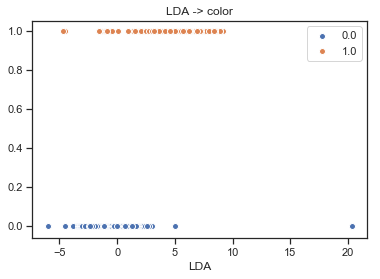

In [8]:
ldaDf = pd.DataFrame(data = LinearDiscriminantAnalysis().fit_transform(wine[D].values, np.ravel(wine[[C]])), columns = ['LDA'])
ldaDf.insert(1, C, wine[[C]].values, True)
fig, ax = plt.subplots()
ax.set_xlabel('LDA')
ax.set_title('LDA -> ' + C)
ax.scatter(ldaDf.loc[ldaDf[C] == 0.0, 'LDA'], np.zeros_like(ldaDf.loc[ldaDf[C] == 0.0, 'LDA']), edgecolors='w')
ax.scatter(ldaDf.loc[ldaDf[C] == 1.0, 'LDA'], np.ones_like(ldaDf.loc[ldaDf[C] == 1.0, 'LDA']), edgecolors='w')
ax.legend([0.0, 1.0])
plt.show()

In [9]:
## bonus: code to iterate through all scalers, it takes ~3mins to run
# for j in [C, L]:
#     scalers = {
#         'z-normalization': train_test_split(StandardScaler().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'RobustScaler': train_test_split(RobustScaler().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'MinMaxScaler': train_test_split(MinMaxScaler().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'MaxAbsScaler': train_test_split(MaxAbsScaler().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'QuantileTransformer': train_test_split(QuantileTransformer(random_state=42).fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'PowerTransformer': train_test_split(PowerTransformer().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'Normalizer': train_test_split(Normalizer().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#         'OrdinalEncoder': train_test_split(OrdinalEncoder().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
# #         'OneHotEncoder': train_test_split(OneHotEncoder().fit_transform(wine[D]), np.ravel(wine[[j]]), test_size=0.2, random_state = 42),
#     }

#     for key, v in scalers.items():
#         plt.plot(range(1,51), [accuracy_score(v[3], KNeighborsClassifier(n_neighbors=k, weights = 'distance', p = 1).fit(v[0], v[2]).predict(v[1])) for k in range(1,51)], label=key)
#     plt.legend()
# #     plt.savefig('Q1_BestParam_' + j + '.png', dpi=300)
#     plt.show()

In [10]:
## bonus: code to iterate through all 11C4 combinations of features, it takes ~30mins to run

# X_train, X_test, y_train, y_test = train_test_split(wine[D].values, np.ravel(wine[[C]]), test_size=0.2, random_state = 42)
# resDictST = {}
# resDict = {'uniform': {}, 'manhattan': {}, 'euclidean': {}}
# selectedDict = {'uniform': {}, 'manhattan': {}, 'euclidean': {}}
# for key, v in params.items():
#     resDictST[key] = [accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k, **v).fit(X_train, y_train).predict(X_test)) for k in range(1,51)]
#     for i in itertools.combinations(range(len(D)), 4):
#         resDict[key][tuple(D[y] for y in i)] = [accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k, **params[key]).fit(X_train[:,list(i)], y_train).predict(X_test[:,list(i)])) for k in range(1,51)]

# for key in params.keys():
#     for k, v in resDict[key].items():
#         if sum(v[i] > resDictST[key][i] for i in range(len(resDictST[key]))) > len(resDictST[key])//2:
#             selectedDict[key][k] = v

# for k, v in selectedDict.items():
#     print([k, v])

In [11]:
df = pd.read_csv('DataB.csv')
df.drop(df.columns[0], axis = 1, inplace=True)
df.loc[:, df.columns != 'gnd'] = StandardScaler().fit_transform(df.loc[:, df.columns != 'gnd'])
s = df.drop('gnd', axis=1).values

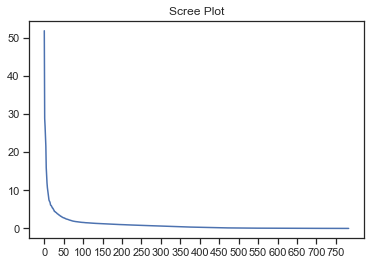

In [12]:
plt.plot(PCA().fit(s).explained_variance_)
plt.xticks(np.arange(0, 800, 50))
plt.title("Scree Plot")
plt.show()

<Figure size 432x288 with 0 Axes>

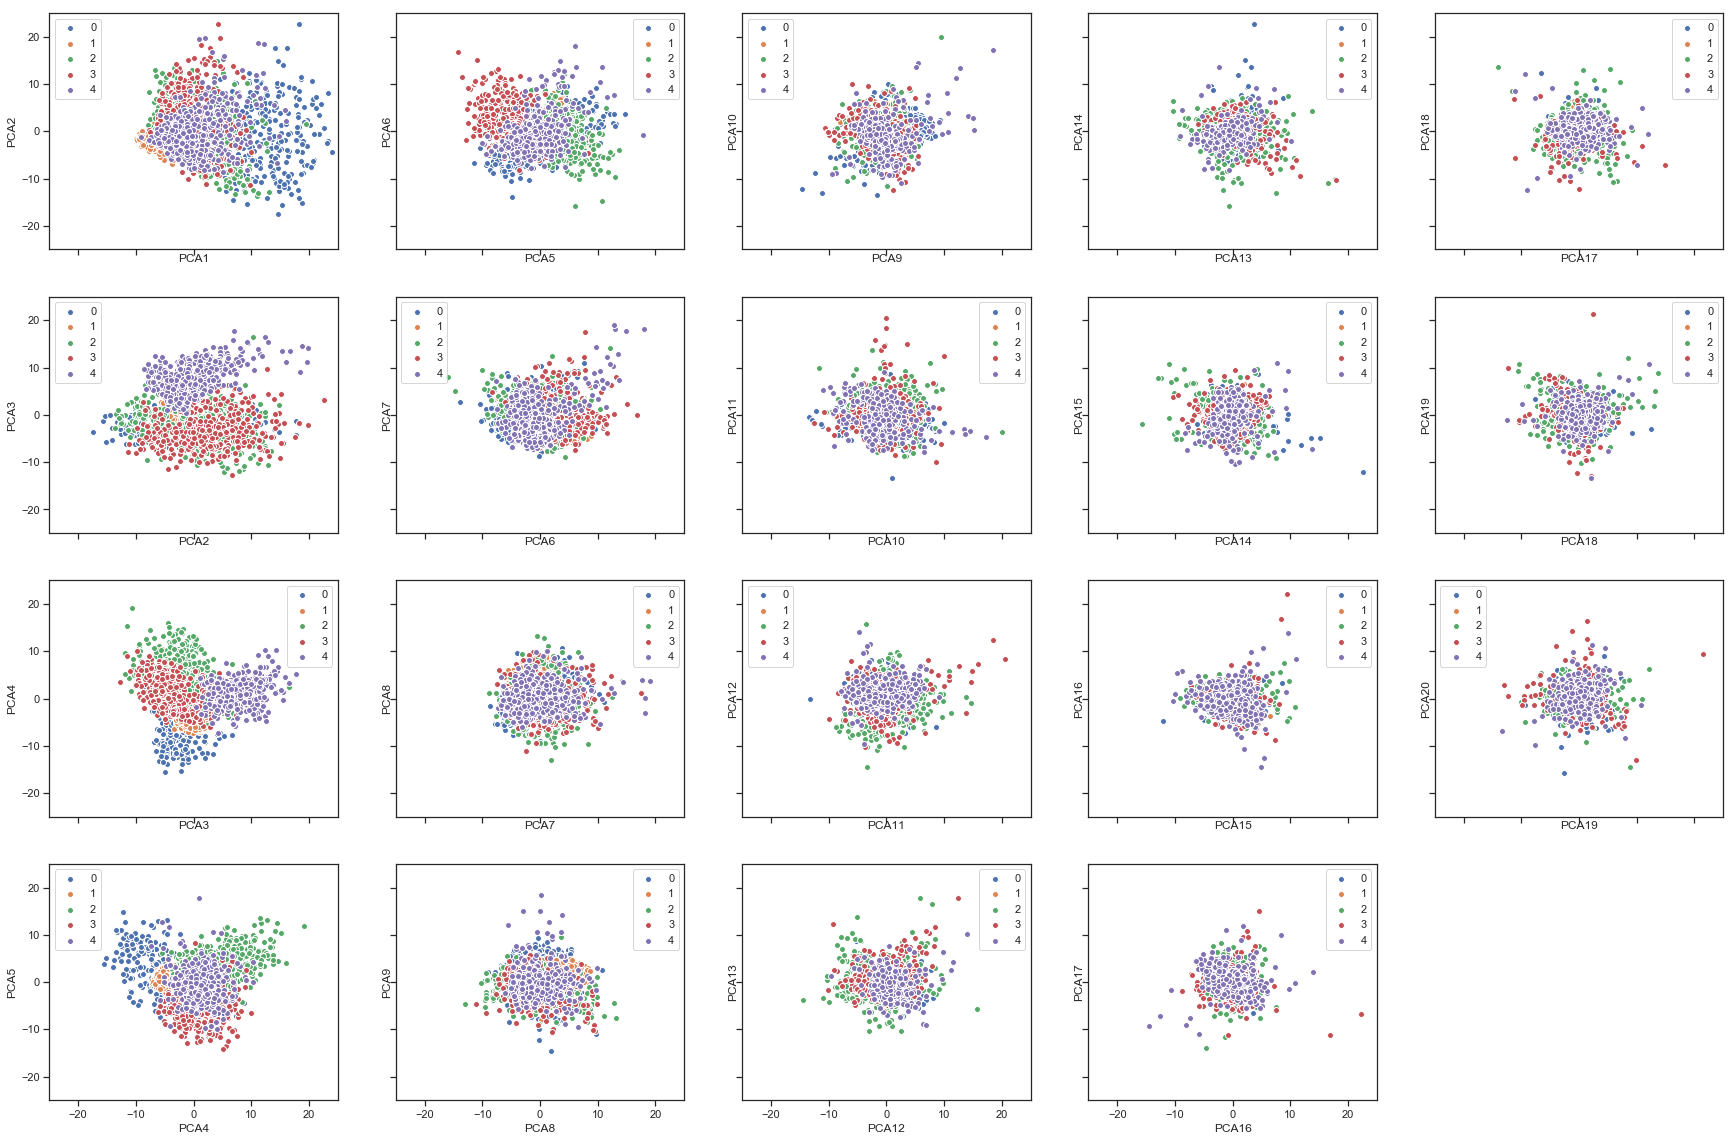

In [13]:
def plotTop(df2, label, total, row, l):
    f = plt.figure()
    f, axes = plt.subplots(nrows = row, ncols = total//row + 1, figsize=(30,20), sharex=True, sharey = True)
    for j in range(total):
        axes[j%row, j//row].set_xlabel(label + str(j+1))
        axes[j%row, j//row].set_ylabel(label + str(j+2))
        [axes[j%row, j//row].scatter(df2.loc[df2['gnd'] == i, j], df2.loc[df2['gnd'] == i, j + 1], edgecolors='w') for i in [*range(5)]]
        axes[j%row, j//row].set_xlim(-1 * l, l)
        axes[j%row, j//row].set_ylim(-1 * l, l)
        axes[j%row, j//row].legend([*range(5)])
    f.delaxes(axes.flatten()[total])
    plt.show()
    
pcaDf = pd.DataFrame(data = PCA(n_components=20).fit_transform(s), columns = [*range(20)])
pcaDf['gnd'] = df[['gnd']]
plotTop(pcaDf, 'PCA', 19, 4, 25)

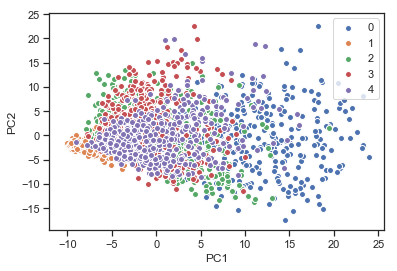

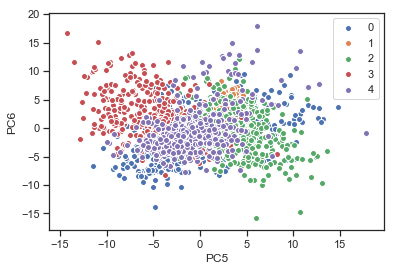

In [14]:
pcaDf = pd.DataFrame(data = PCA(n_components=6).fit_transform(df.drop('gnd', axis=1).values))
pcaDf['gnd'] = df[['gnd']]
for j in [[0, 1], [4, 5]]:
    fig, ax = plt.subplots()
    ax.set_xlabel('PC' + str(j[0]+1))
    ax.set_ylabel('PC' + str(j[1]+1))
    [ax.scatter(pcaDf.loc[pcaDf['gnd'] == i, j[0]], pcaDf.loc[pcaDf['gnd'] == i, j[1]], edgecolors='w') for i in [0, 1, 2, 3, 4]]
    ax.legend([0, 1, 2, 3, 4])
    plt.show()

<Figure size 432x288 with 0 Axes>

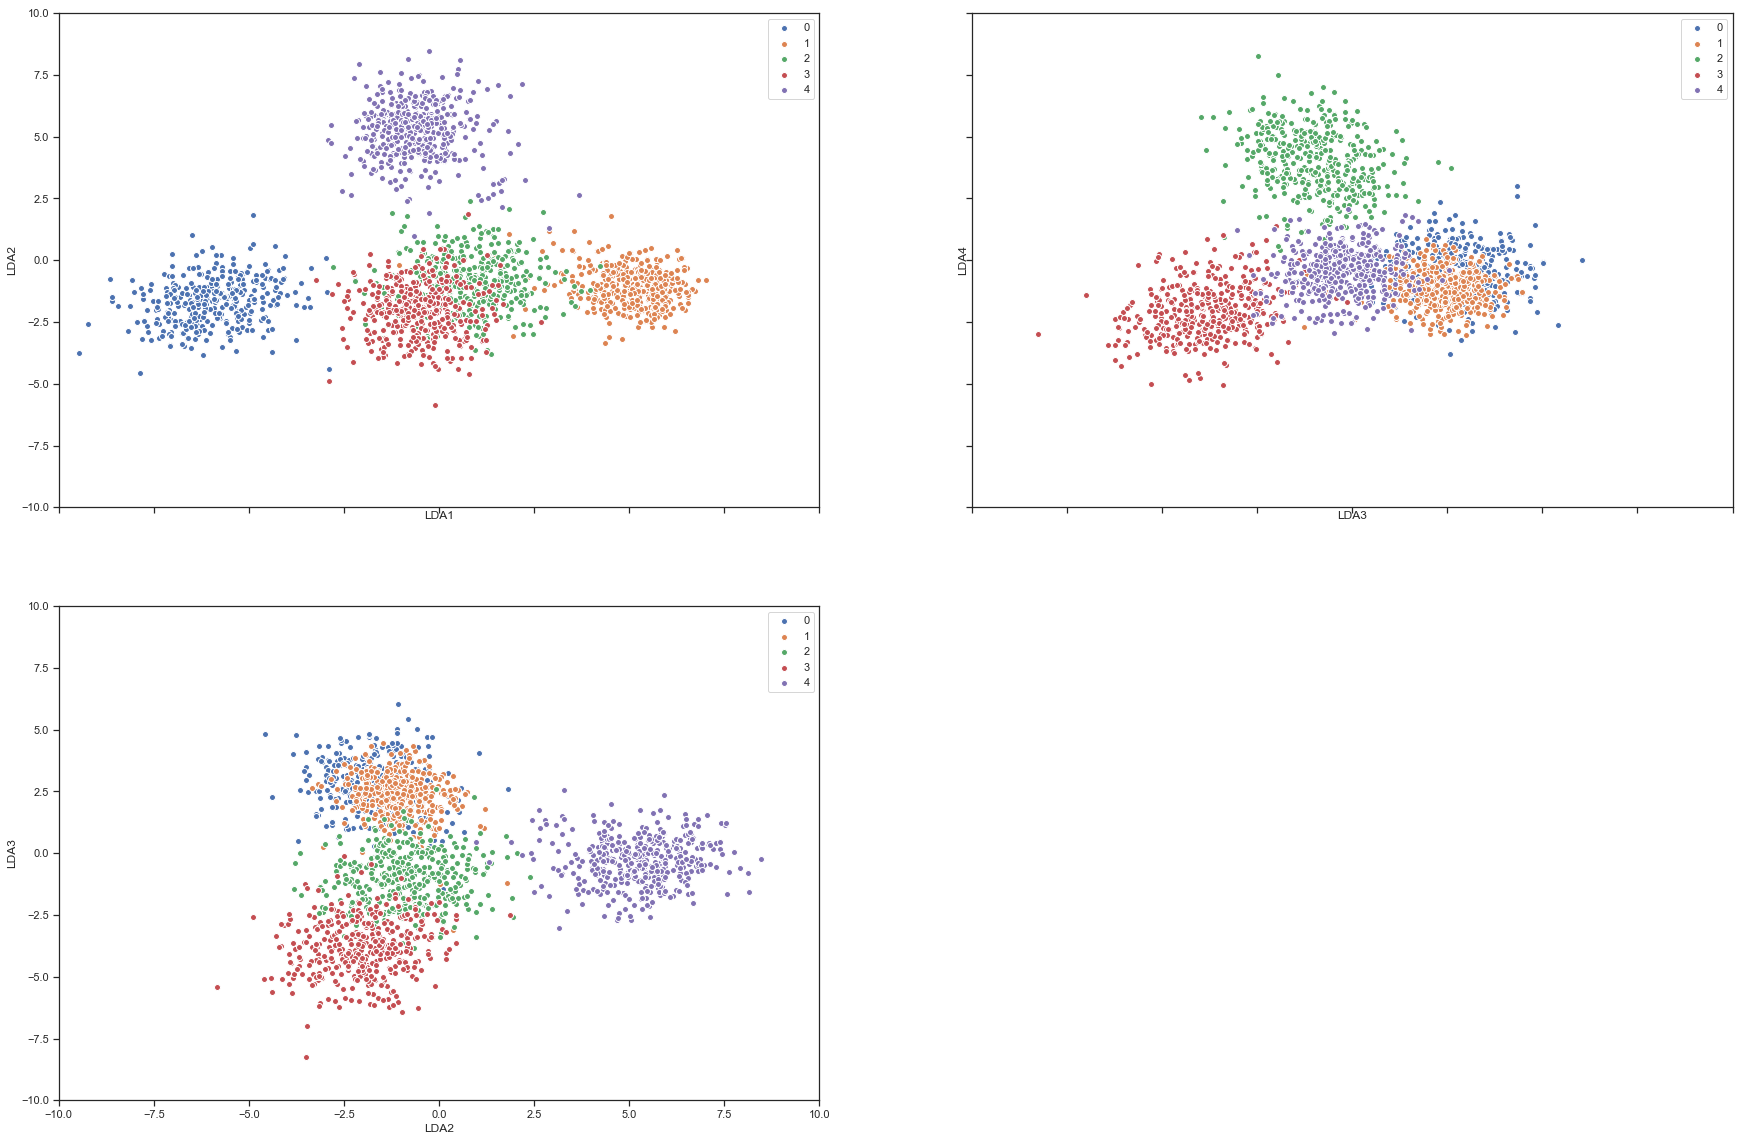

In [15]:
ldaDf = pd.DataFrame(data = LinearDiscriminantAnalysis().fit_transform(s, np.ravel(df[['gnd']])), columns = [*range(4)])
ldaDf['gnd'] = df[['gnd']]
plotTop(ldaDf, 'LDA', 3, 2, 10)

In [16]:
# input: an n*t array, n is the dimensionality and t is the number of training examples
def svd_np(x):
    eigValueU, eigVectorU = np.linalg.eigh(np.dot(x, x.T))
    eigValueV, eigVectorV = np.linalg.eigh(np.dot(x.T, x))
    idxU = eigValueU.argsort()[::-1]
    idxV = eigValueV.argsort()[::-1]
    return eigVectorU[:,idxU], np.sqrt(eigValueV[idxV] if x.shape[0] > x.shape[1] else eigValueU[idxU]), eigVectorV[:,idxV].T

U, sigma, Vt = svd_np(s.T)

In [17]:
# check if (sigma * Vt).T has the same result with build in PCA
print(np.allclose(np.absolute(np.diag(sigma).dot(Vt[:s.shape[1],:]).T), np.absolute(PCA().fit_transform(s))))

# check if (U.T.dot(s.T)).T, which is s.dot(U), has the same result with build in PCA
print(np.allclose(np.absolute(s.dot(U)), np.absolute(PCA().fit_transform(s))))

True
True


In [18]:
df = pd.read_csv('DataB.csv')
df.drop(df.columns[0], axis = 1, inplace=True)
df.loc[:, df.columns != 'gnd'] = StandardScaler().fit_transform(df.loc[:, df.columns != 'gnd'])
dfs = {
    'Kernel_PCA': KernelPCA(n_components=2, kernel='rbf', random_state=42).fit_transform(df.drop('gnd', axis=1)),
    'Isomap': Isomap(n_components=2).fit_transform(df.drop('gnd', axis=1)),
    'Locally_Linear_Embedding': LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(df.drop('gnd', axis=1)),
    'Laplacian_Eigenmap': SpectralEmbedding(n_components=2).fit_transform(df.drop('gnd', axis=1)),
    't-SNE': TSNE(n_components=2, random_state=42).fit_transform(df.drop('gnd', axis=1))
}

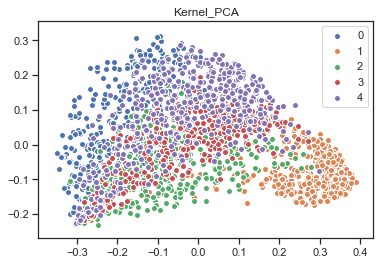

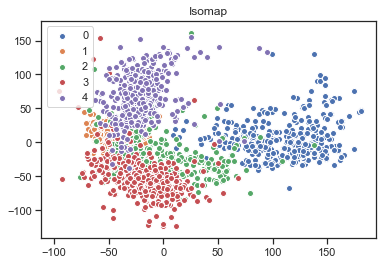

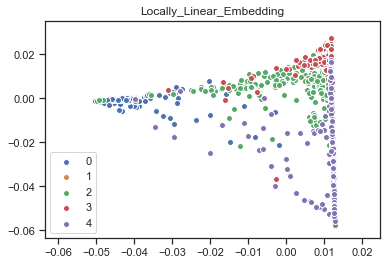

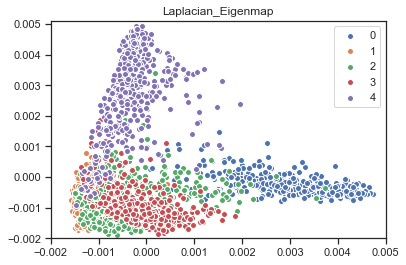

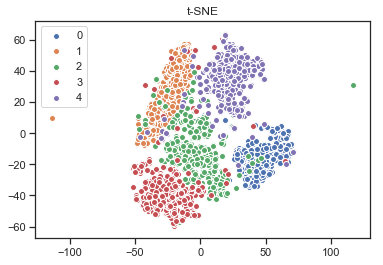

In [19]:
for k, v in dfs.items():
    vDf = pd.DataFrame(data = v, columns = [1, 2])
    vDf['gnd'] = df[['gnd']]
    fig, ax = plt.subplots()
    [ax.scatter(vDf.loc[vDf['gnd'] == i, 1], vDf.loc[vDf['gnd'] == i, 2], edgecolors='w') for i in [0, 1, 2, 3, 4]]
    ax.set_title(k)
    if k == 'Laplacian_Eigenmap':
        ax.set_xlim(-0.002, 0.005)
        ax.set_ylim(-0.002, 0.0051)
    ax.legend([0, 1, 2, 3, 4])
    plt.show()